# NN Model Propeller - Pure data-driven

Works quite well - follows the time varying part

In [1]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from torchviz import make_dot
from scipy.fftpack import fft, ifft

import matplotlib.pyplot as plt

import joblib

In [2]:
import datetime
date = datetime.date.today()
# print(date)

## Dataset class

In [28]:
       
# Condition function to filter subdirectories
def subdir_condition(subdir_name):
    """
    Condition: Only process subdirectories whose names start with 'propeller-example_dji'.
    Modify this function to apply a specific filtering logic.
    """
    return subdir_name.startswith('rotor_dataset')  # Change this condition as needed


class PropellerDataset(Dataset):
    # def __init__(self, root_dir, alpha, J, theta, yaw, tilt, subdir_condition=None):
    def __init__(self, root_dir, subdir_condition=None):
        """
        Args:
            root_dir (string): Root directory with subdirectories containing CSV files.
            alpha (float): Angle of attack.
            J (float): Advance ratio.
            theta (float): Pitch.
            yaw (float): Yaw.
            tilt (float): Tilt.
            subdir_condition (callable, optional): A function or condition to filter subdirectories by name.
        """
        self.root_dir = root_dir
        self.data = []
        self.targets = []
        self.time_data = []  # Store time data separately
        self.omega_data = []  # Store omega (RPM) separately
        self.ct_data = []
        self.cq_data = []
        self.fft_ct_r = []
        self.fft_ct_i = []
        self.fft_cq_r = []
        self.fft_cq_i = []
        self.subdir_condition = subdir_condition

        # Traverse the root directory to gather data
        self._load_data()

    def _load_data(self):
        """
        Helper function to read CSV files from each subdirectory and extract relevant columns.
        """
        # Iterate through each subdirectory in the root directory
        for subdir, _, files in os.walk(self.root_dir):
            subdir_name = os.path.basename(subdir)
            
            # Apply subdirectory name condition
            if self.subdir_condition and not self.subdir_condition(subdir_name):
                continue

            for file in files:
                if file.endswith("_convergence.csv"):
                    # Load the CSV file
                    csv_path = os.path.join(subdir, file)
                    df = pd.read_csv(csv_path)
                    # df = df[(df['ref age (deg)']) < 1800]
                    # print("Length:",len(df))
                    
                    # Extract necessary columns for input features
                    time = df['T'].values  # Time
                    omega = df['RPM_1'].values  # RPM
                    J = df['J'].values
                    AOA = df['AOA'].values
                    v_inf = df['v_inf'].values
                    pitch = df['Pitch (blade)'].values
                    tilt = df['Tilt'].values
                    yaw = df['Yaw'].values
                    ref_angle = df['ref age (deg)'].values

                    # Store time and omega in separate lists for easy access
                    self.time_data.append(time)
                    self.omega_data.append(omega)
                    
                    # Extract CT and CQ as output variables
                    ct = df['CT_1'].values  # Thrust coefficient (CT)
                    cq = df['CQ_1'].values  # Torque coefficient (CQ)

                    fft_ct = fft(ct)
                    fft_ct_real = np.real(fft_ct)
                    fft_ct_imag = np.imag(fft_ct)

                    fft_cq = fft(cq)
                    fft_cq_real = np.real(fft_cq)
                    fft_cq_imag = np.imag(fft_cq)

                    
                    # Store ct and cq in separate lists for easy access
                    self.ct_data.append(ct)
                    self.cq_data.append(cq)
                    self.fft_ct_r.append(fft_ct_real)
                    self.fft_ct_i.append(fft_ct_imag)
                    self.fft_cq_r.append(fft_cq_real)
                    self.fft_cq_i.append(fft_cq_imag)

                    # For each simulation, the input sequence is structured as (n_timesteps, n_features)
                    sequence_inputs = []
                    sequence_outputs = []
                    for i in range(len(time)):
                        # Each time step has time, omega, and predefined variables: alpha, J, theta, yaw, tilt
                        input_data = [
                            # time[i], ref_angle[i], omega[i], (100*np.sin(omega[i]*time[i])), 
                            # (100*np.cos(omega[i]*time[i])), AOA[i], J[i], pitch[i], tilt[i], yaw[i]
                            time[i],  omega[i], AOA[i], v_inf[i], (100*np.sin(omega[i]*time[i])), 
                            (100*np.cos(omega[i]*time[i])), J[i], pitch[i], tilt[i], yaw[i]
                            # omega[i], AOA[i], J[i], pitch[i], tilt[i], yaw[i]
                        ]
                        # output_data = [ct[i], cq[i], fft_ct_imag[i], fft_cq_imag[i]]
                        output_data = [ct[i], cq[i]]
                        # output_data = [fft_ct_real[i], fft_ct_imag[i], fft_cq_real[i], fft_cq_imag[i]]
                        
                        
                        sequence_inputs.append(input_data)
                        sequence_outputs.append(output_data)

                    sequence_inputs = np.array([sequence_inputs], dtype=float)
                    sequence_outputs = np.array([sequence_outputs], dtype=float)

                    # Append input sequence (n_timesteps, num_features) and output (CT, CQ)
                    self.data.append(sequence_inputs)
                    self.targets.append(sequence_outputs)  # Append the whole CT and CQ sequences


    def __len__(self):
        """
        Returns the total number of sequences in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a single sequence and its targets.
        """
        print(f"Requested index: {idx}")
        print(f"Dataset length: {len(self.data)}")  # Check if idx exceeds this
        print(f"Targets length: {len(self.targets)}")
        
        inputs = self.data[idx]  # Input sequence: (n_timesteps, n_features)
        targets = self.targets[idx]  # Output: (n_timesteps, 2)
        
        # return inputs, targets
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

    def get_variable(self, variable_name):
        """
        Returns a list of arrays for the specified variable.
        Args:
            'time' - timesteps
            'omega' - rotational velocity [RPM]
            'CT' - Thrust coefficient
            'CQ' - Torque coefficient
            'fft_ct_r' - Thrust ccoefficient FFT - real part
            'fft_ct_i' - Thrust ccoefficient FFT - imag part
            'fft_cq_r' - Torque ccoefficient FFT - real part
            'fft_cq_i' - Torque ccoefficient FFT - imag part

        """
        if variable_name == 'time':
            return self.time_data  # Return all time steps for each simulation
        elif variable_name == 'omega':
            return self.omega_data  # Return all omega (RPM) values for each simulation
        elif variable_name == 'CT':
            return self.ct_data 
        elif variable_name == 'CQ':
            return self.cq_data
        elif variable_name == 'fft_ct':
            return self.fft_ct_r, self.fft_ct_i 
        elif variable_name == 'fft_cq':
            return self.fft_cq_r, self.fft_cq_i  
        else:
            raise ValueError(f"Variable {variable_name} not supported.")



In [4]:
# Define the custom dataset class
# Creates training and validation datasets
class SimulationDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.outputs[idx], dtype=torch.float32)

## Extract and organize data

In [5]:
def visualize_tabular_dataset(inputs, targets, visualize:bool):
    
    if visualize:
        # Additional part to visualize the data
        df_ips = [None]*len(inputs)
        df_ops = [None]*len(targets)

        for num_batch in range(len(inputs)):
            df_ips[num_batch] = pd.DataFrame(inputs[num_batch], columns=["timestep", "sin_comp", "cos_comp", "Omega", "alpha", "J", "theta", "tilt", "yaw"])
            # df_ops[num_batch] = pd.DataFrame(targets[num_batch], columns=["CT", "CQ", "fft_ct_imag", "fft_cq_imag"])
            df_ops[num_batch] = pd.DataFrame(targets[num_batch], columns=["fft_ct_real", "fft_ct_imag", "fft_cq_real", "fft_cq_imag"])

        print("Input dataset\n", df_ips)
        print("Target dataset\n", df_ops)

In [6]:
# Root directory where simulation subdirectories are stored
root_dir = "/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/rotor_data/training_data"

visualize_dataset = True         # Visualize loaded dataset
visualize_norm_dataset = False   # Visualize normalized dataset
visualize_nn = True              # Visulaize NN structure

In [29]:
# Create the dataset with a subdirectory condition

dataset = PropellerDataset(root_dir, subdir_condition=subdir_condition)
inputs, outputs = dataset[0:]


input_tensor = inputs.squeeze(1)  # Reshaping
print("Input shape:", input_tensor.shape)   # Should print: torch.Size([Num_sumulations, tsteps_per_simulations, 10])

output_tensor = outputs.squeeze(1)
print("Output shape:",output_tensor.shape)  # Should print: torch.Size([Num_sumulations, tsteps_per_simulations, 4])


Requested index: slice(0, None, None)
Dataset length: 68
Targets length: 68
Input shape: torch.Size([68, 181, 10])
Output shape: torch.Size([68, 181, 2])


## NN Model

In [8]:
# LSTM Model Definition
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out)
        return out
    

In [9]:
# class LSTMNetWithAttention(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, bias=0.0):
#         super(LSTMNetWithAttention, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.bias = nn.Parameter(torch.tensor(bias))  # Learnable bias term

#         # LSTM layer
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

#         # Multi-head attention layer
#         self.multihead_attention = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)

#         # Fully connected output layer
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         """
#         x: Input tensor of shape (batch_size, seq_length, input_size)
#         """
#         # Pass through LSTM
#         lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_length, hidden_size)

#         # Multi-head attention: Query, Key, and Value are all lstm_out
#         attention_output, attention_weights = self.multihead_attention(lstm_out, lstm_out, lstm_out)

#         # Pass attention output through the fully connected layer
#         output = self.fc(attention_output)  # (batch_size, seq_length, output_size)

#         # Add bias to the output
#         output = output + self.bias

        # return output, attention_weights

In [10]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Train the model

### Define Hyperparameters

In [11]:
# Hyperparameters
input_size = 10             # Number of input features
hidden_size = 100            # Number of LSTM units (hidden state size)
output_size = 2             # Number of output features (e.g., 2 for thrust and torque coefficients)
num_layers = 4              # Number of LSTM layers
learning_rate = 1e-3         # Learning rate
num_epochs = 2500           # Number of training epochs
batch_size = 2              # Batch size 

### Normalize the dataset

In [12]:
# Initialize scalers for input and output
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

# input_scaler = StandardScaler()
# output_scaler = StandardScaler()

# Reshape data for scaling (flatten along the time dimension)
inputs_reshaped = input_tensor.reshape(-1, input_size)
outputs_reshaped = output_tensor.reshape(-1, output_size)

# Fit and transform inputs and outputs
inputs_normalized = input_scaler.fit_transform(inputs_reshaped).reshape(input_tensor.shape)
outputs_normalized = output_scaler.fit_transform(outputs_reshaped).reshape(output_tensor.shape)

print("Normalized input shape:", inputs_normalized.shape)
print("Normalized output shape:", outputs_normalized.shape)

# View dataset in tabular form - change visualize to True
visualize_tabular_dataset(inputs_normalized, outputs_normalized, visualize=visualize_norm_dataset)

Normalized input shape: (68, 181, 10)
Normalized output shape: (68, 181, 2)


### Split the dataset

In [13]:
test_percentage = 0.35   # Percentage of data to be used for testing

train_dataset_num = len(dataset) - int(len(dataset)*test_percentage)    
print("Number of datasets to be used for training:", train_dataset_num)
print("Number of datasets to be used for evaluation:", len(dataset) - train_dataset_num)

# Create the normalized dataset using the custom Dataset class
train_dataset = SimulationDataset(inputs_normalized[:train_dataset_num], outputs_normalized[:train_dataset_num])    # First 70% for training
val_dataset = SimulationDataset(inputs_normalized[train_dataset_num:], outputs_normalized[train_dataset_num:])      # Remaining for evaluation

# Create DataLoaders
trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    # Shuffle training data
valDataLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)        # Shuffle validation data


Number of datasets to be used for training: 45
Number of datasets to be used for evaluation: 23


### Training ...

In [14]:
class WeightedMSELoss(nn.Module):
    def __init__(self, underprediction_weight=2.0):
        """
        Custom Weighted MSE Loss to penalize underpredictions.
        Args:
            underprediction_weight (float): Weight for penalizing underpredictions.
        """
        super(WeightedMSELoss, self).__init__()
        self.underprediction_weight = underprediction_weight

    def forward(self, predictions, targets):
        """
        Compute the weighted MSE loss.
        Args:
            predictions (torch.Tensor): Predicted values (shape: [batch_size, ...]).
            targets (torch.Tensor): Actual values (shape: [batch_size, ...]).
        Returns:
            torch.Tensor: Weighted MSE loss value.
        """
        # Compute the error
        error = predictions - targets

        # Identify underpredictions (error < 0)
        underprediction_mask = (error < 0).float()

        # Assign weights: underpredictions get a higher weight
        weights = 0.1 + underprediction_mask * (self.underprediction_weight - 1.0)

        # Compute weighted squared error
        squared_error = error ** 2
        weighted_squared_error = weights * squared_error

        # Compute the mean loss
        loss = torch.mean(weighted_squared_error)
        return loss

In [15]:
def custom_loss(pred, target):
    return torch.mean((pred - target) ** 2) + 0.5 * torch.mean(torch.abs(pred - target))

In [16]:

# Instantiate model, loss function, and optimizer
num_heads = 2   # Number of attention heads
bias = 0.0  # Learnable bias term
# model = LSTMNetWithAttention(input_size, hidden_size, output_size, num_layers, num_heads, bias).to(device)

model = LSTMNet(input_size, hidden_size, output_size, num_layers).to(device)    # LSTM model
# criterion = nn.MSELoss()                                                        # Loss function                                     
criterion = custom_loss   
# criterion = WeightedMSELoss(underprediction_weight= 15.5)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
eval_losses = []

print("[INFO] training the network...")

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in trainDataLoader:
        inputs, targets = inputs.squeeze(1).to(device), targets.squeeze(1).to(device)

        # Forward pass
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainDataLoader)
    train_losses.append(avg_train_loss)


    # Evaluation Loop
    model.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for inputs, targets in valDataLoader:
            inputs, targets = inputs.squeeze(1).to(device), targets.squeeze(1).to(device)
            
            # Forward pass
            outputs = model(inputs)
            # outputs, attention_weights = model(inputs)

            loss = criterion(outputs, targets)
            eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(valDataLoader)
        eval_losses.append(avg_eval_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}],\n Training Loss: {running_loss/len(trainDataLoader):.8f}')
    print(f'Evaluation Loss: {eval_loss/len(valDataLoader):.8f}')

print("\nFinished Training...")

[INFO] training the network...
Epoch [1/2500],
 Training Loss: 0.06972136
Evaluation Loss: 0.00952089
Epoch [2/2500],
 Training Loss: 0.01343520
Evaluation Loss: 0.00828087
Epoch [3/2500],
 Training Loss: 0.01484405
Evaluation Loss: 0.00451366
Epoch [4/2500],
 Training Loss: 0.01124570
Evaluation Loss: 0.00525279
Epoch [5/2500],
 Training Loss: 0.01241979
Evaluation Loss: 0.00856795
Epoch [6/2500],
 Training Loss: 0.01079377
Evaluation Loss: 0.00423087
Epoch [7/2500],
 Training Loss: 0.01123335
Evaluation Loss: 0.00779357
Epoch [8/2500],
 Training Loss: 0.01068848
Evaluation Loss: 0.00883129
Epoch [9/2500],
 Training Loss: 0.01181414
Evaluation Loss: 0.00747555
Epoch [10/2500],
 Training Loss: 0.01171488
Evaluation Loss: 0.00716521
Epoch [11/2500],
 Training Loss: 0.01123358
Evaluation Loss: 0.00747720
Epoch [12/2500],
 Training Loss: 0.01133159
Evaluation Loss: 0.00685653
Epoch [13/2500],
 Training Loss: 0.01075230
Evaluation Loss: 0.00390119
Epoch [14/2500],
 Training Loss: 0.0103756

### Plot the losses

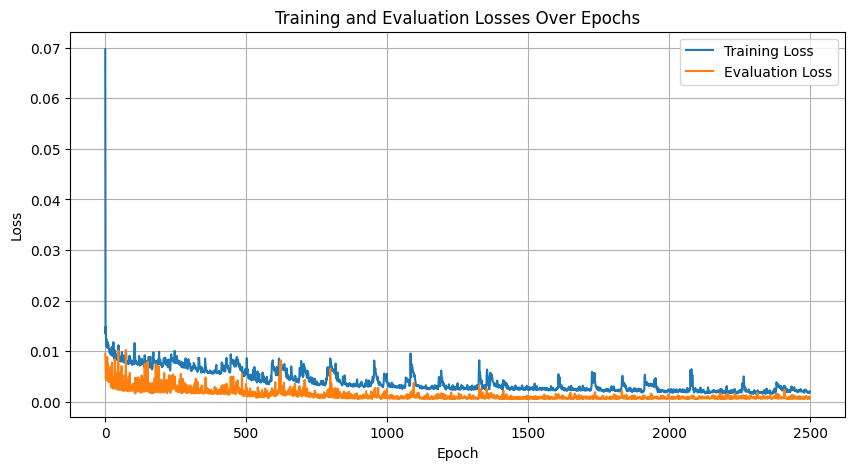

In [17]:
# Plotting the training and evaluation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Visualize NN structure

In [18]:
# # Create a dummy input tensor (batch_size, elements)
# # Assuming 170 elements, batch_size = 1
# dummy_input = torch.randn(1, 10, 7).to(device)

# # Pass the dummy input through the model
# dummy_output = model(dummy_input)

# # Generate the computational graph
# dot = make_dot(dummy_output, params=dict(model.named_parameters()))

# # Display the graph
# dot

### Save the model

In [22]:
# Save the model if needed
# save_path =  './Trained_models/{}_propModel_lr{}_e{}_nL{}_numNN{}.pth'.format(date, learning_rate, num_epochs, num_layers, hidden_size)

# save_path =  '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/rotor/{}_modified_H26FpropModel_lr{}_e{}_nL{}_numNN{}.pth'.format(date, learning_rate, num_epochs, num_layers, hidden_size)
# print("The model will be saved as the following:\n {}".format(save_path))


# torch.save(model.state_dict(), save_path)

The model will be saved as the following:
 /mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/rotor/2025-01-30_modified_H26FpropModel_lr0.001_e2500_nL4_numNN100.pth


### Save the scalers

In [23]:
# # save the scalers

# # './saved_scalers/{}_ipScaler_lr{}_e{}_nL{}_numNN{}.pkl'.format(date, learning_rate, num_epochs, num_layers, hidden_size)
# joblib.dump(input_scaler, './saved_scalers/{}_ipScaler_lr{}_e{}_nL{}_numNN{}.pkl'.format(date, learning_rate, num_epochs, num_layers, hidden_size))
# joblib.dump(output_scaler, './saved_scalers/{}_opScaler_lr{}_e{}_nL{}_numNN{}.pkl'.format(date, learning_rate, num_epochs, num_layers, hidden_size))

# joblib.dump(input_scaler, '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/rotor/{}_modified_H26F_ipScaler_lr{}_e{}_nL{}_numNN{}.pkl'.format(date, learning_rate, num_epochs, num_layers, hidden_size))
# joblib.dump(output_scaler, '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/rotor/{}_modified_H26F_opScaler_lr{}_e{}_nL{}_numNN{}.pkl'.format(date, learning_rate, num_epochs, num_layers, hidden_size))


['/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/rotor/2025-01-30_modified_H26F_opScaler_lr0.001_e2500_nL4_numNN100.pkl']

## Test the model

Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 2])
Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 2])
Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 2])
Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 2])
Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 2])
Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 2])
Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 2])
Input shape: torch.Size([1, 181, 10])
Output shape: torch.Size([1, 181, 2])


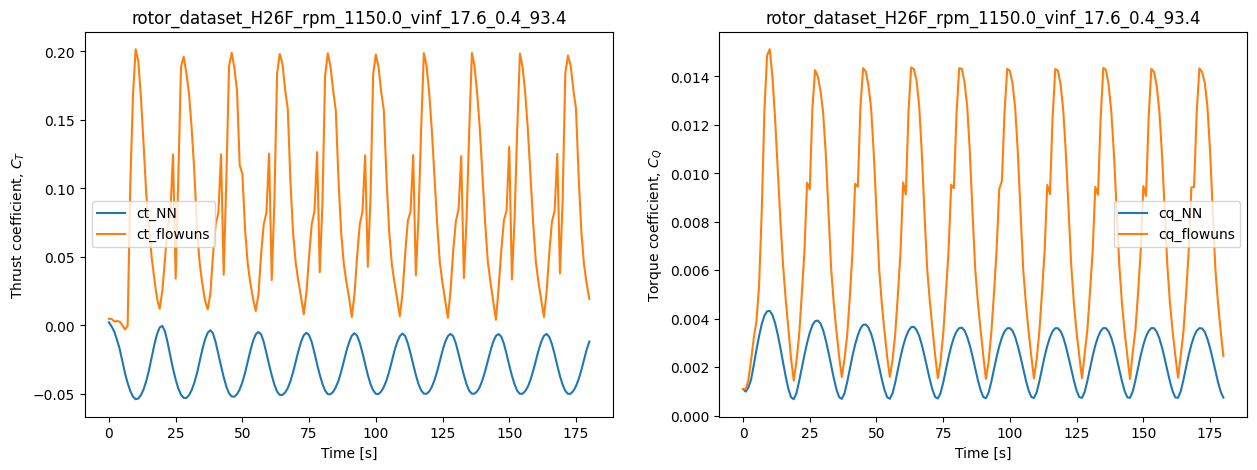

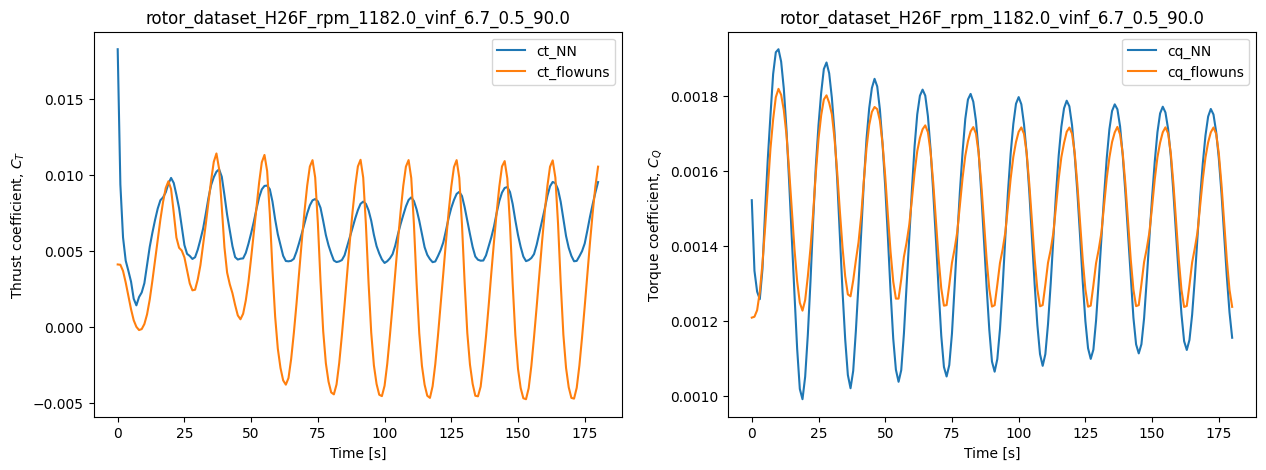

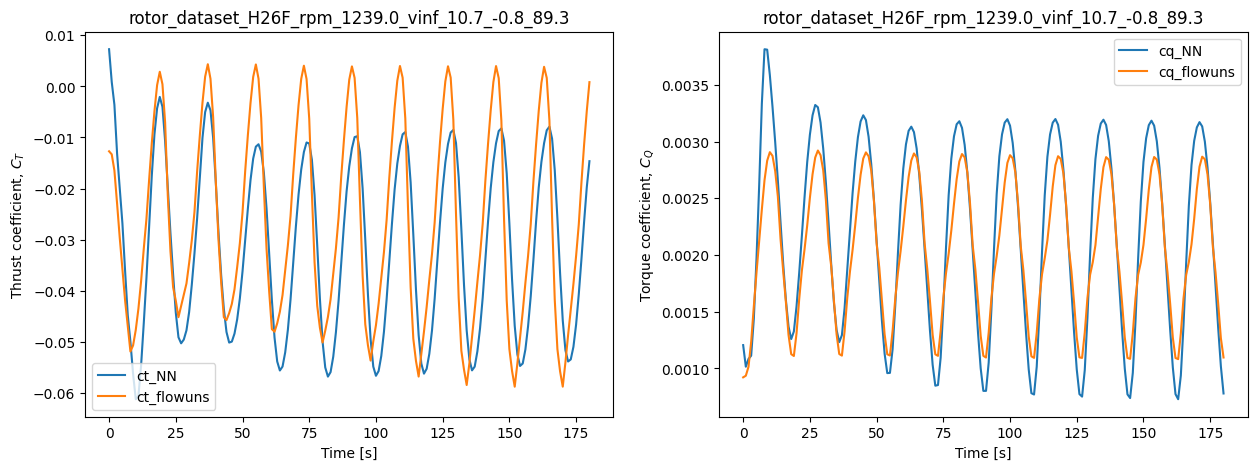

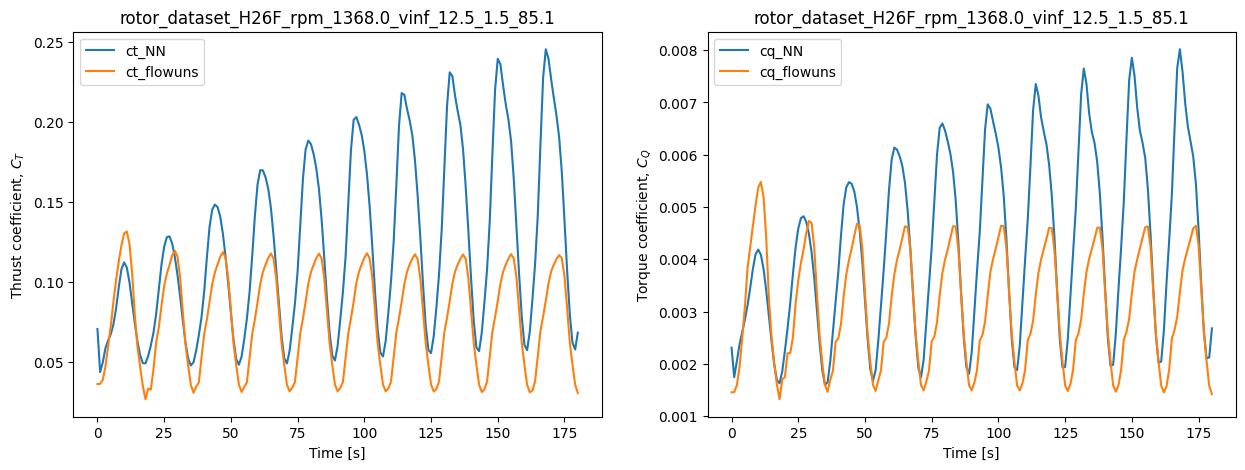

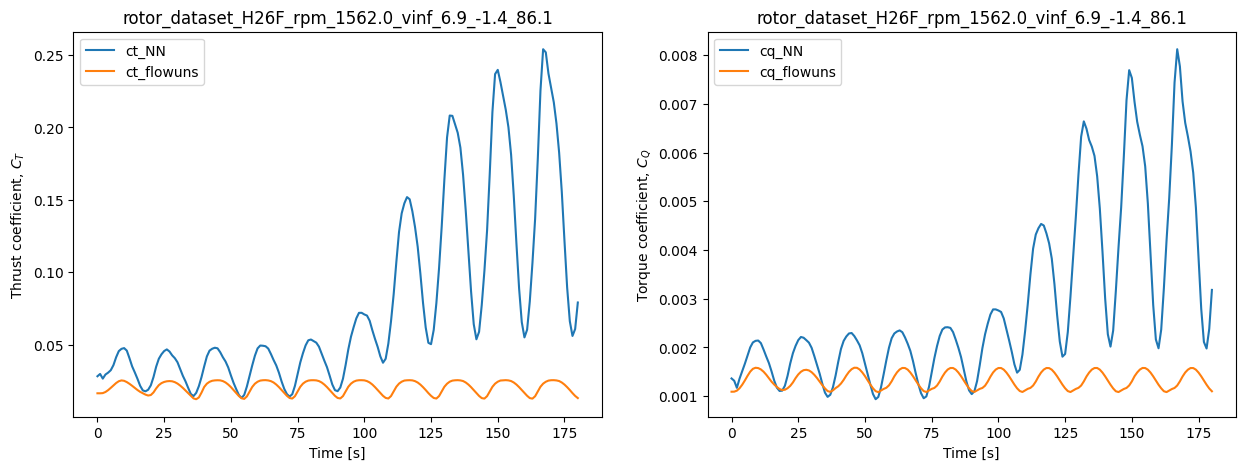

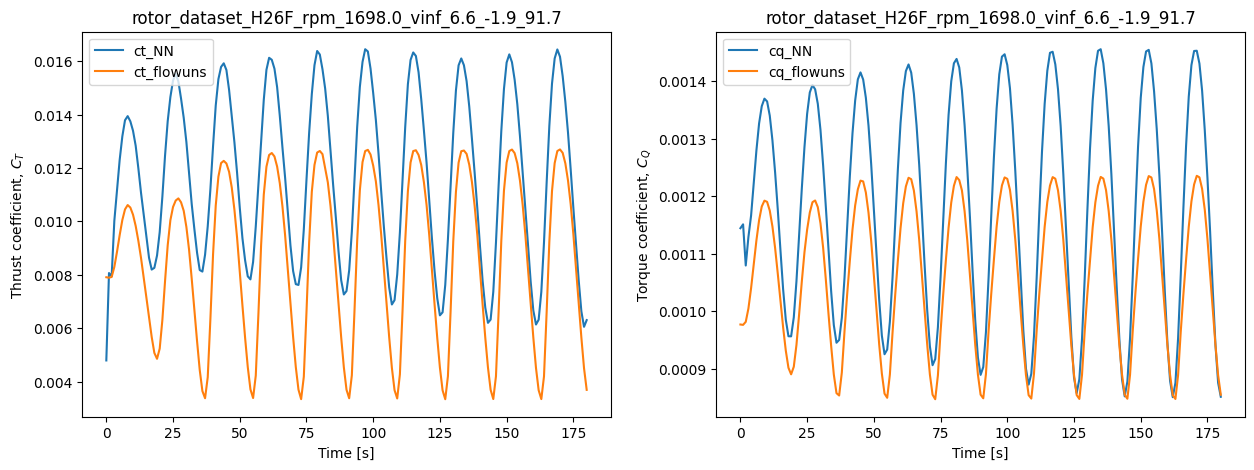

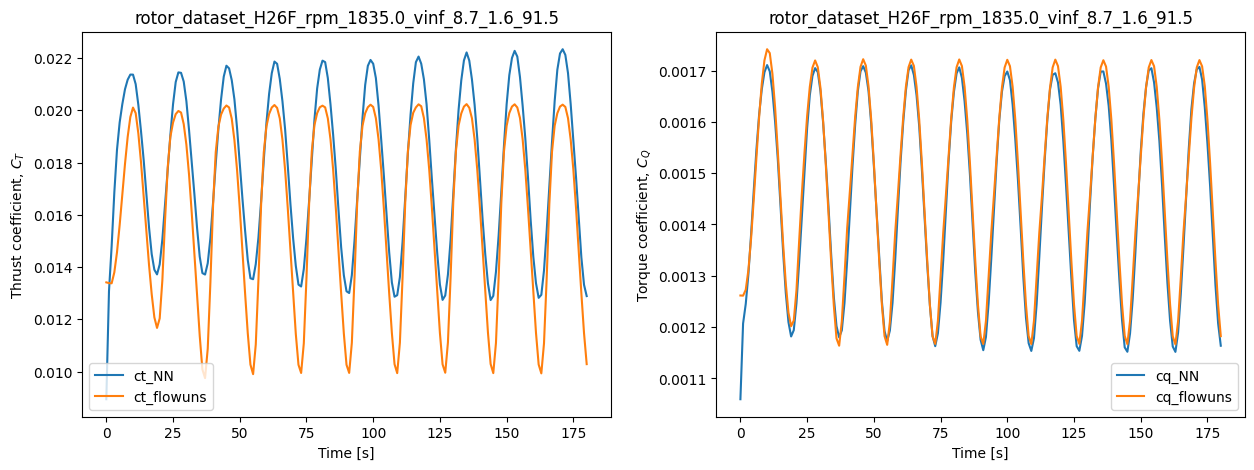

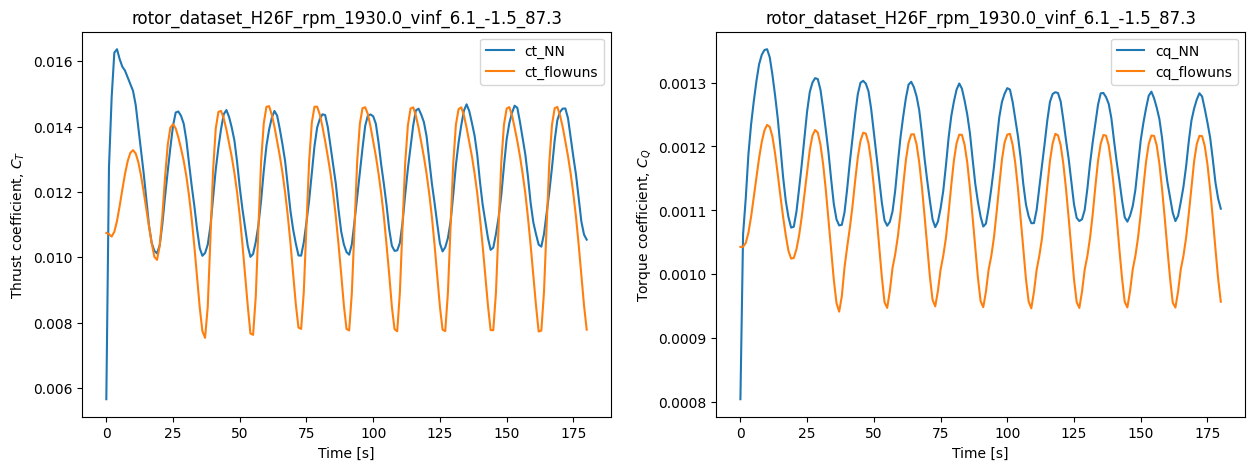

In [21]:
# Root directory where simulation subdirectories are stored
root_dir_test_base = "/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/rotor_data/testing_data/"

for simulation_case in os.listdir(root_dir_test_base):
    # Root directory where simulation subdirectories are stored
    root_dir_test_sim = root_dir_test_base+simulation_case
  

    # Create the dataset with a subdirectory condition
    # dataset_test = PropellerDataset(root_dir_test_sim, alpha_test, J_test, theta_test, yaw_test, tilt_test, subdir_condition=subdir_condition)
    dataset_test = PropellerDataset(root_dir_test_sim, subdir_condition=subdir_condition)
    inputs_test, outputs_test = dataset_test[0:]

    # Assuming your input tensor is named `input_tensor`
    input_tensor_test = inputs_test.squeeze(1)  # Remove the singleton dimension at index 1
    print("Input shape:", input_tensor_test.shape)  # Should print: torch.Size([6, 145, 7])

    output_tensor_test = outputs_test.squeeze(1)
    print("Output shape:",output_tensor_test.shape)

    inputs_test_reshaped = input_tensor_test.reshape(-1, input_size)

    test_inputs_normalized = input_scaler.transform(inputs_test_reshaped.reshape(-1, input_size)).reshape(input_tensor_test.shape)

    test_inputs_tensor = torch.tensor(test_inputs_normalized, dtype=torch.float32).to(device)

    # Make predictions using the trained model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predicted_outputs = model(test_inputs_tensor)
        # predicted_outputs, attention_weights = model(test_inputs_tensor)


    # Convert the predictions back to numpy and inverse scale the outputs
    predicted_outputs = predicted_outputs.cpu().detach().numpy()  # Convert tensor to numpy array
    predicted_outputs_original_scale = output_scaler.inverse_transform(predicted_outputs.reshape(-1, output_size))

    # Reshape the predictions to match the original sequence structure if needed
    predicted_outputs_original_scale = predicted_outputs_original_scale.reshape(input_tensor_test.shape[0], input_tensor_test.shape[1], output_size)
    predicted_outputs_original_scale = predicted_outputs_original_scale[0]

    # print(predicted_outputs_original_scale.shape)

    # Model predicted values
    ct_test_NN = predicted_outputs_original_scale[:,0]
    cq_test_NN = predicted_outputs_original_scale[:,1]

    # fft_ct_nn_real = predicted_outputs_original_scale[:,0]
    # fft_cq_nn_real = predicted_outputs_original_scale[:,2]
    
    # fft_ct_nn_imag = predicted_outputs_original_scale[:,1]
    # fft_cq_nn_imag = predicted_outputs_original_scale[:,3]

    # Load timesteps, CT and CQ from FLOWUnsteady simualtions
    time_steps = dataset_test.get_variable('time')

    ct_test_flowuns = dataset_test.get_variable('CT')
    cq_test_flowuns = dataset_test.get_variable('CQ')

    fft_ct_fu_real, fft_ct_fu_imag = dataset_test.get_variable('fft_ct')
    fft_cq_fu_real, fft_cq_fu_imag = dataset_test.get_variable('fft_cq')

    # complex_ct_nn = fft_ct_nn_real +1j * fft_ct_nn_imag
    # ct_test_NN = ifft(complex_ct_nn)

    # complex_cq_nn = fft_cq_nn_real +1j * fft_cq_nn_imag
    # cq_test_NN = ifft(complex_cq_nn)

    # complex_fft_coeff = real_part_nn + 1j * imaginary_part_actual

    

    # Plot the results

    # plt.figure()
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    # plt.plot(time_steps[0], ct_test_NN, label = 'ct_NN')
    # plt.plot(time_steps[0], (ct_test_flowuns[0]), label = 'ct_flowuns')
    plt.plot(ct_test_NN, label = 'ct_NN')
    plt.plot((ct_test_flowuns[0]), label = 'ct_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Thrust coefficient, $C_T$')
    plt.title(simulation_case)
    plt.legend()

    # plt.figure()
    plt.subplot(1, 2, 2)
    # plt.plot(time_steps[0], cq_test_NN, label = 'cq_NN')
    # plt.plot(time_steps[0], cq_test_flowuns[0], label = 'cq_flowuns')
    plt.plot(cq_test_NN, label = 'cq_NN')
    plt.plot(cq_test_flowuns[0], label = 'cq_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Torque coefficient, $C_Q$')
    plt.title(simulation_case)
    plt.legend()
